In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops


def preprocess_image(image: np.ndarray, channel) -> np.ndarray:
    """
    Preprocessing Step:
    - Extract red channel
    - Apply 3x3 median filter
    - Scale by factor 1.64

    Args:
        image (np.ndarray): Input RGB image

    Returns:
        np.ndarray: Scaled red channel image (I_new_red)
    """
    value = image[:, :, channel]  # V channel for brightness
    value_filtered = cv2.medianBlur(value, 3)
    value_scaled = np.clip(1.5 * value_filtered, 0, 255).astype(np.uint8)
    return value_scaled

def horizontal_filter(value_channel):
    height, width = value_channel.shape
    result = np.zeros_like(value_channel)

    for y in range(height):
        for x in range(3, width - 3):
            window = value_channel[y, x - 3:x + 4]
            if np.ptp(window) > 2:
                result[y, x] = np.min(window)
            else:
                result[y, x] = value_channel[y, x]
    return result

def vertical_filter(value_channel):
    height, width = value_channel.shape
    result = np.zeros_like(value_channel)

    for x in range(width):
        for y in range(3, height - 3):
            window = value_channel[y - 3:y + 4, x]
            if np.ptp(window) > 5:
                result[y, x] = np.min(window)
            else:
                result[y, x] = value_channel[y, x]
    return result

def estimate_background(value_channel):
    h_filtered = horizontal_filter(value_channel)
    v_filtered = vertical_filter(value_channel)
    return np.maximum(h_filtered, v_filtered)

def enhance_hair(background, value_channel):
    return cv2.subtract(background, value_channel)

from skimage.filters import threshold_otsu
from skimage.morphology import closing, disk, remove_small_objects

def segment_dark_hair(enhanced):
    thresh = threshold_otsu(enhanced)
    binary = (enhanced > thresh + 1).astype(np.uint8)
    binary = closing(binary, disk(5))
    binary = remove_small_objects(binary.astype(bool), min_size=1)
    return binary.astype(np.uint8)

def detect_white_hair(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    # White hairs: High value, low saturation
    white_mask = (v > 200) & (s < 50)
    white_mask = white_mask.astype(np.uint8)
    white_mask = closing(white_mask, disk(1))
    white_mask = remove_small_objects(white_mask.astype(bool), min_size=15)
    return white_mask.astype(np.uint8)

def inpaint_image(image, combined_mask):
    mask = (combined_mask * 255).astype(np.uint8)
    return cv2.inpaint(image, mask, 3, cv2.INPAINT_NS)



def simple_postprocess_hair_mask(hair_mask: np.ndarray) -> np.ndarray:
    """
    Postprocess the hair mask by:
    - Skeletonizing
    - Splitting segments at branch points (simplified)
    - Filtering small or round objects as noise (approximate classifier)

    Args:
        hair_mask (np.ndarray): Initial binary hair mask

    Returns:
        np.ndarray: Refined binary hair mask
    """
    # Step 1: Skeletonize and find components
    skeleton = skeletonize(hair_mask // 255).astype(np.uint8)
    labeled = label(skeleton, connectivity=2)
    final_mask = np.zeros_like(hair_mask)

    # Step 2: Filter based on heuristics
    for region in regionprops(labeled):
        if region.area < 10:
            continue

        eccentricity = region.eccentricity
        minr, minc, maxr, maxc = region.bbox
        width = max(maxc - minc, maxr - minr)

        # Heuristic classifier: eccentric and long = likely hair
        if eccentricity > 0.9 and width > 10:
            coords = region.coords
            for y, x in coords:
                final_mask[y, x] = 255

    # Step 3: Morphological closing to restore continuity
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, np.ones((5, 5), dtype=np.uint8))
    return final_mask

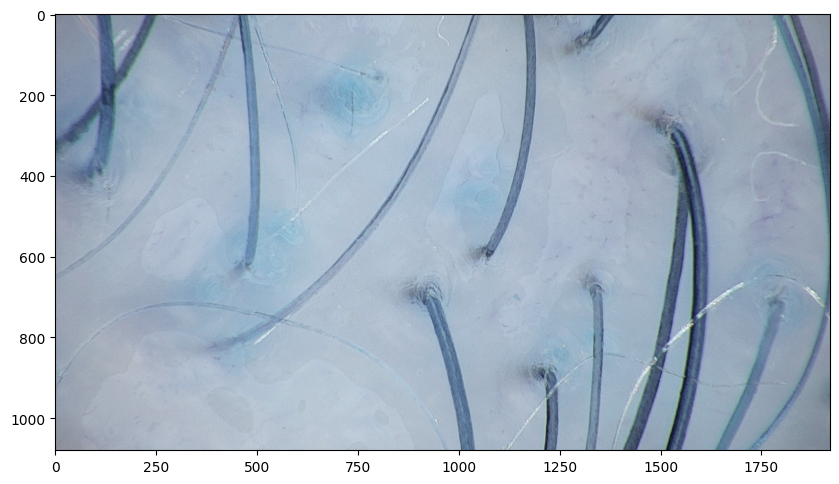

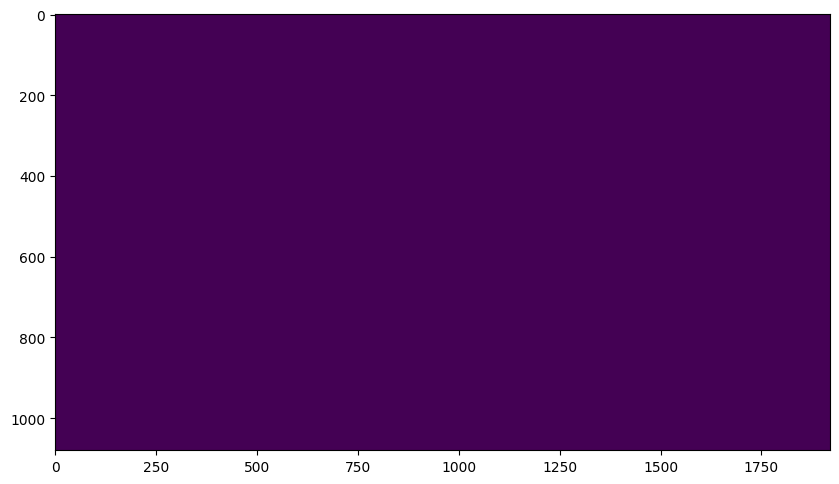

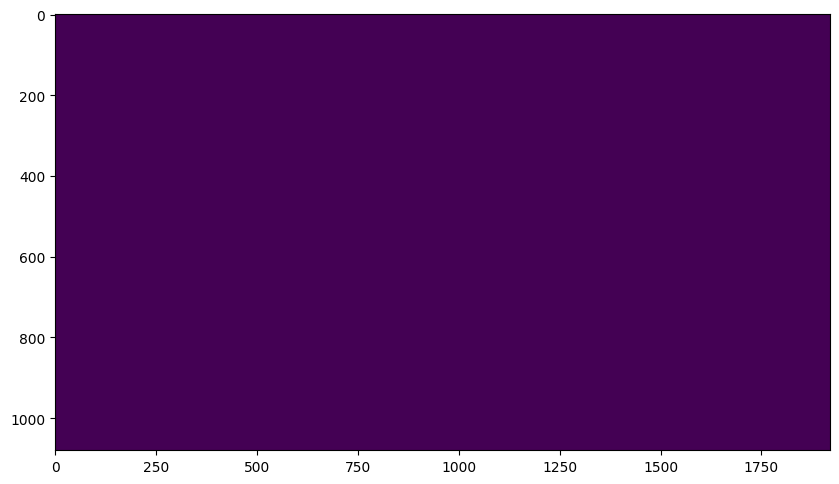

In [17]:
image = cv2.imread("./łysienie/03945.jpg") #03943.jpg

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

value = preprocess_image(hsv, 2)
# background = estimate_background(value)
enhanced = enhance_hair(hsv[:,:,2], value)
dark_hair_mask = segment_dark_hair(enhanced)

plt.figure(figsize=(10,8))
plt.imshow(image)

# plt.figure(figsize=(10,8))
# plt.imshow(background)

plt.figure(figsize=(10,8))
plt.imshow(enhanced)

plt.figure(figsize=(10,8))
plt.imshow(dark_hair_mask)

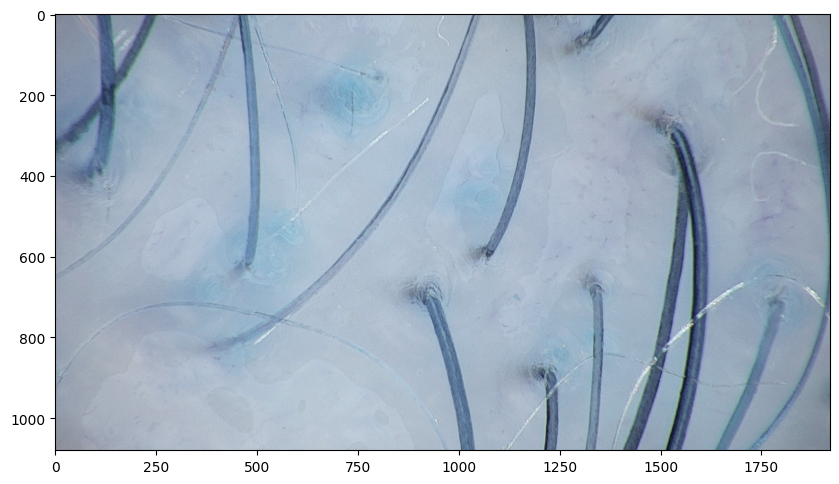

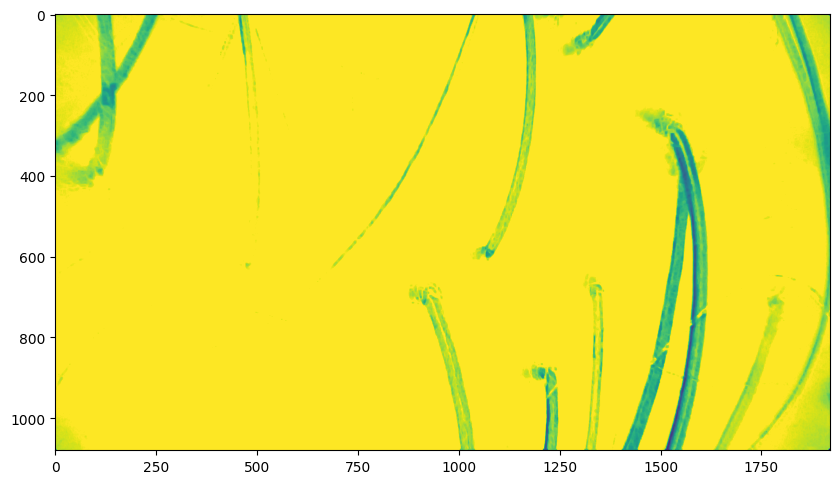

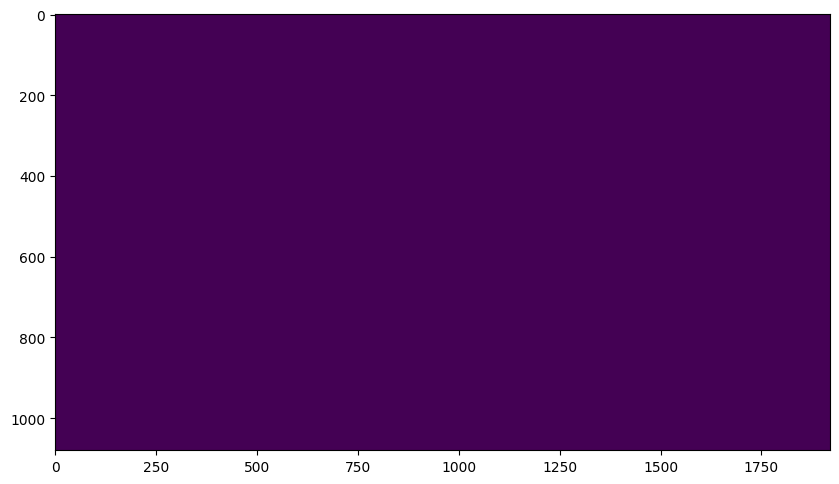

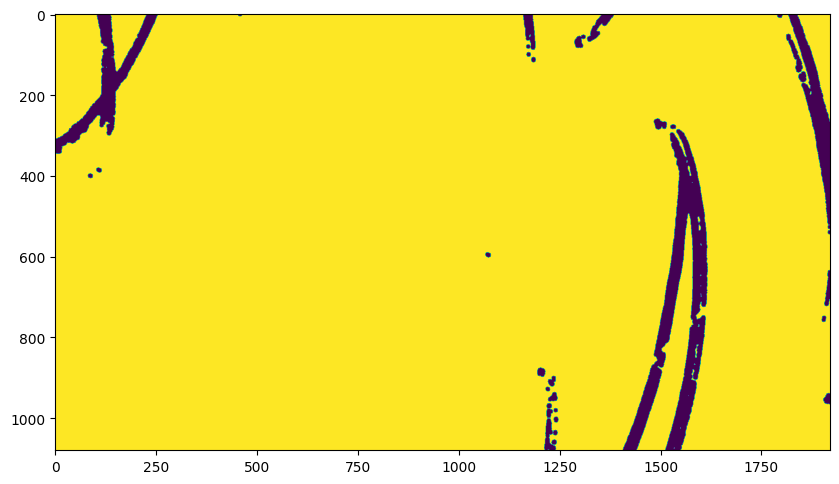

In [20]:
image = cv2.imread("./łysienie/03945.jpg") #03943.jpg

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

value = preprocess_image(hsv, 2)
background = estimate_background(value)
enhanced = enhance_hair(background, value)

dark_hair_mask = segment_dark_hair(value)
# white_hair_mask = detect_white_hair(value)

# full_mask = cv2.bitwise_or(dark_hair_mask, white_hair_mask)
# inpainted = inpaint_image(image, full_mask)

plt.figure(figsize=(10,8))
plt.imshow(image)

plt.figure(figsize=(10,8))
plt.imshow(background)


plt.figure(figsize=(10,8))
plt.imshow(enhanced)

plt.figure(figsize=(10,8))
plt.imshow(dark_hair_mask)

# plt.figure(figsize=(10,8))
# plt.imshow(white_hair_mask)

# plt.figure(figsize=(10,8))
# plt.imshow(inpainted)

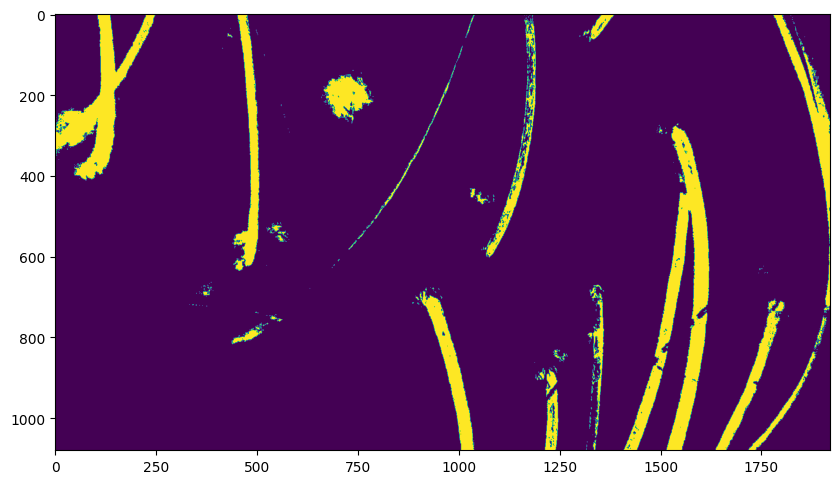

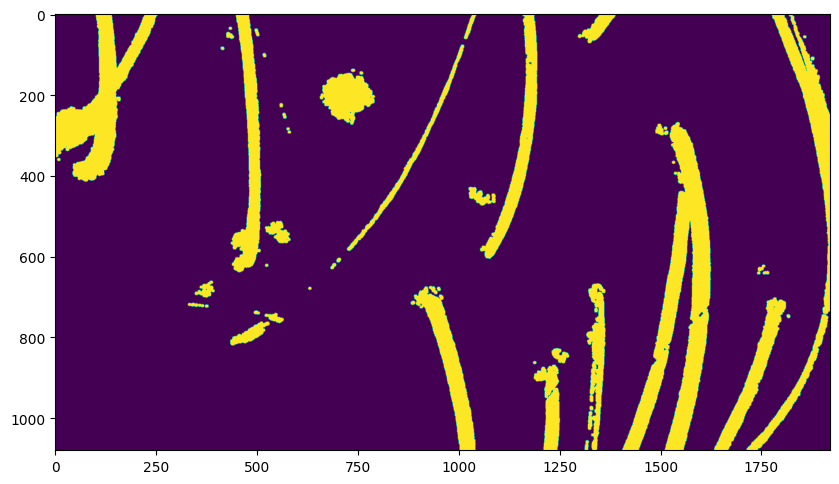

In [51]:
from cv2 import dilate

image = cv2.imread("./łysienie/03945.jpg") #03943.jpg

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

binary_enchanced = cv2.inRange(hsv[:, :, 1], 80, 255)
# _, binary_enchanced = cv2.threshold(hsv[:, :, 1], 60, 255, cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
dilation = cv2.dilate(binary_enchanced, kernel, iterations = 1)
open = cv2.morphologyEx(binary_enchanced, cv2.MORPH_CLOSE, kernel)

# inpainted = cv2.inpaint(image, dilation, 10, cv2.INPAINT_TELEA)

plt.figure(figsize=(10,8))
plt.imshow(binary_enchanced)

plt.figure(figsize=(10,8))
plt.imshow(dilation)

# plt.figure(figsize=(10,8))
# plt.imshow(inpainted)

Text(0.5, 1.0, '2 - 0')

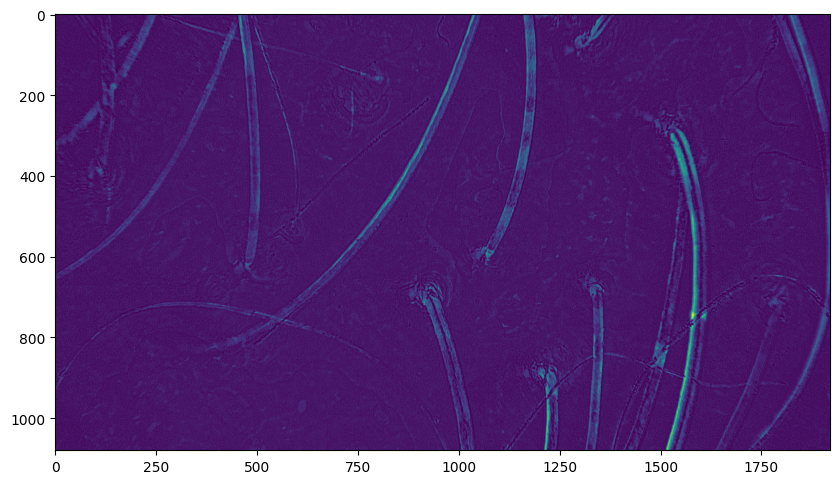

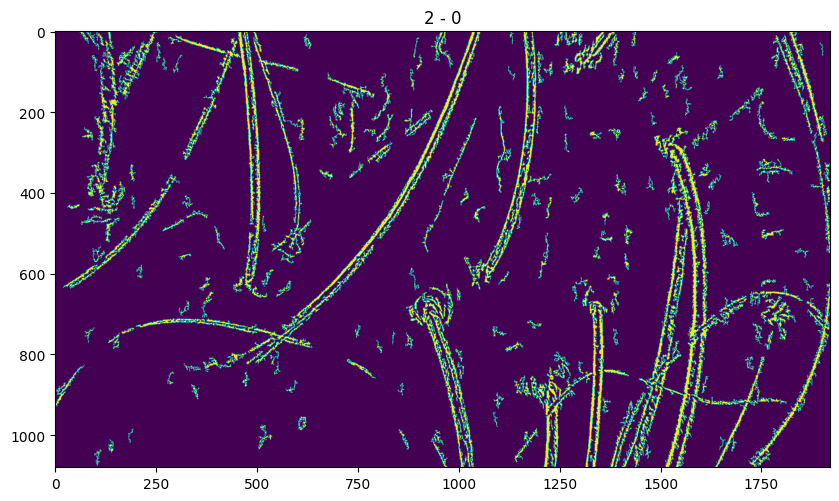

In [29]:
enhanced_blue = cv2.subtract(background, image[:,:,2])
white_mask = detect_white_hairs(enhanced_blue, image[:,:,0])


plt.figure(figsize=(10,8))
plt.imshow(enhanced_blue)

plt.figure(figsize=(10,8))
plt.imshow(white_mask)
plt.title("2 - 0")

In [6]:
def detect_white_hairs(blue_plane: np.ndarray, red_plane: np.ndarray) -> np.ndarray:
    """
    Detect white/light-colored hairs based on the difference between
    the blue channel and its median-filtered version.

    Args:
        blue_plane (np.ndarray): Blue channel of the RGB image

    Returns:
        np.ndarray: Binary mask of white hairs
    """
    blue_plane_copy = blue_plane.copy()
    red_plane_copy = red_plane.copy()

    # Step 1: Median filter
    Igm = cv2.medianBlur(blue_plane_copy, 15)

    # Step 2: White hair enhancement
    WH = cv2.subtract(blue_plane_copy, Igm)

    # # Step 3: Threshold at 1 to binarize
    _, WH_binary = cv2.threshold(WH, 1, 255, cv2.THRESH_BINARY)

    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # tophat = cv2.morphologyEx(blue_plane, cv2.MORPH_TOPHAT, kernel)

    # _, WH_binary = cv2.threshold(tophat, 1, 255, cv2.THRESH_BINARY)

    # # Step 4: Filter out non-hair-like shapes
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(WH_binary, connectivity=8)
    filtered = np.zeros_like(WH_binary)

    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]

        min_area = 10
        if area < min_area:
            continue

        aspect_ratio = max(w, h)
        eccentricity = aspect_ratio / (min(w, h) + 1e-5)
        rect_area = w * h
        fill_ratio = area / (rect_area + 1e-5)

        # Extract mask of the component
        component_mask = (labels == i).astype(np.uint8)
        # non_245_values = component_mask[component_mask != 0]
        # print(non_245_values)
        # print(component_mask.shape)
        
        # Mask original blue plane to get intensities in this component
        # Extract pixel values from blue and red planes
        component_pixels_blue = blue_plane_copy[component_mask == 1]
        component_pixels_red = red_plane_copy[component_mask == 1]

        # Check if any pixel is darker than 210
        # White hair has high intenstiy value pixel in blue channel - above ~210
        # Dark hair has low intenstiy value pixel in blue channel - below ~120
        if np.any((component_pixels_blue > 150) & (component_pixels_blue < 190)):
            continue  # Discard this componen

        # Skip if any pixel in red channel is ≥ 190
        # if np.any(component_pixels_red >= 0):
        #     continue

        if aspect_ratio > 30 and eccentricity > 0.9 and fill_ratio < 0.8:
            
            # 👇 Print pixel values from WH before binarization
            # component_pixels_wh = WH[component_mask == 1]
            # print(f"Component {i} WH values:", np.unique(component_pixels_wh))

            filtered[labels == i] = 255

    return filtered

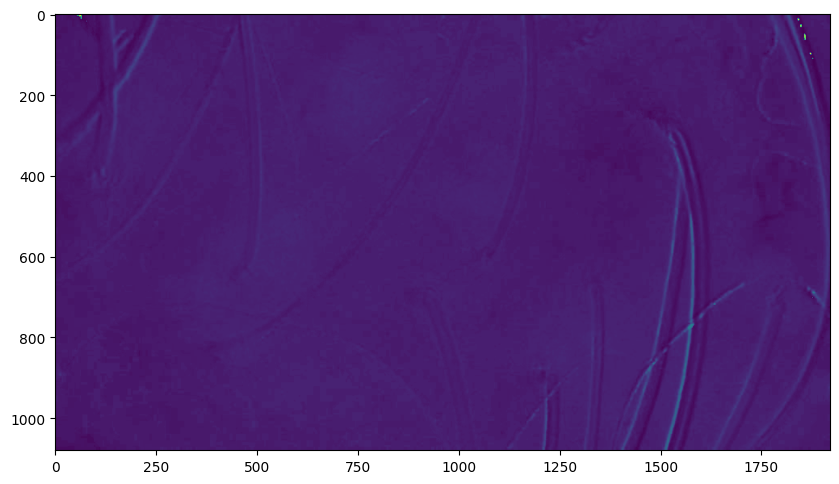

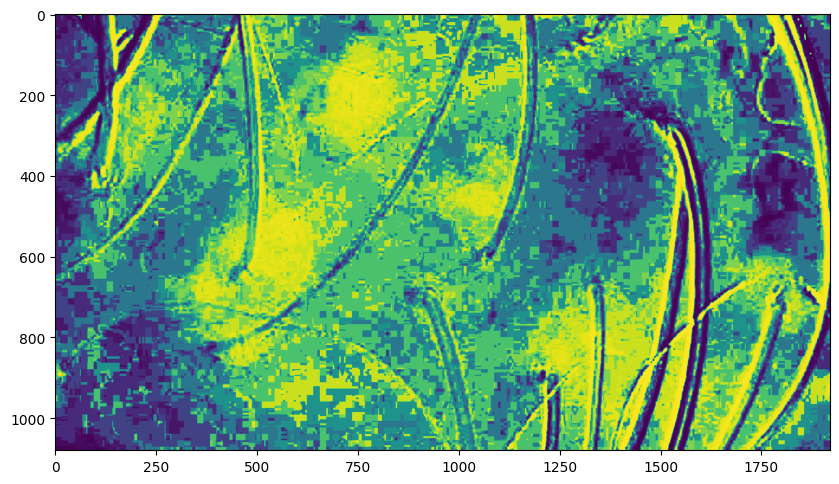

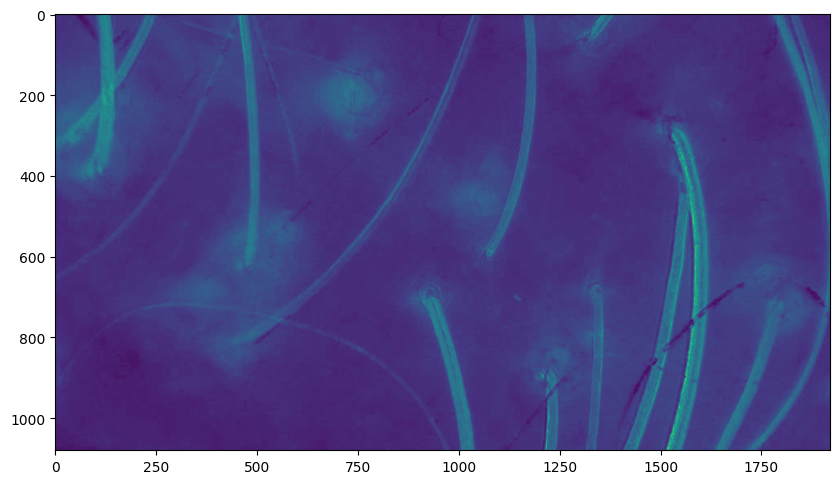

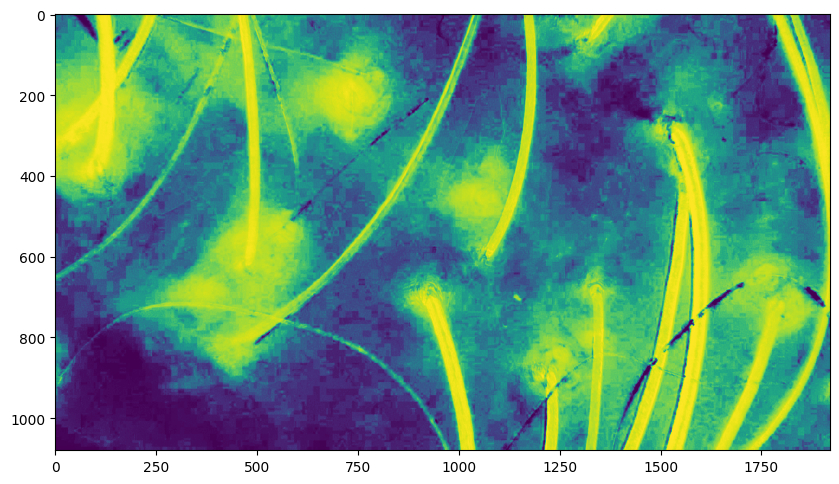

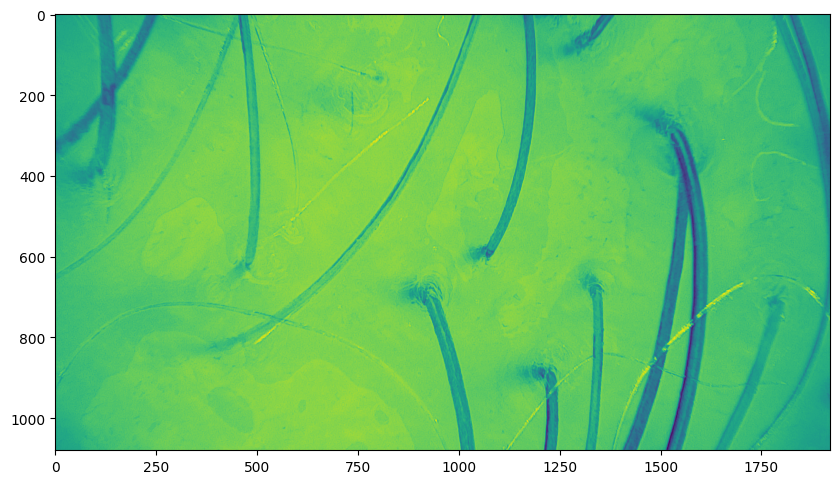

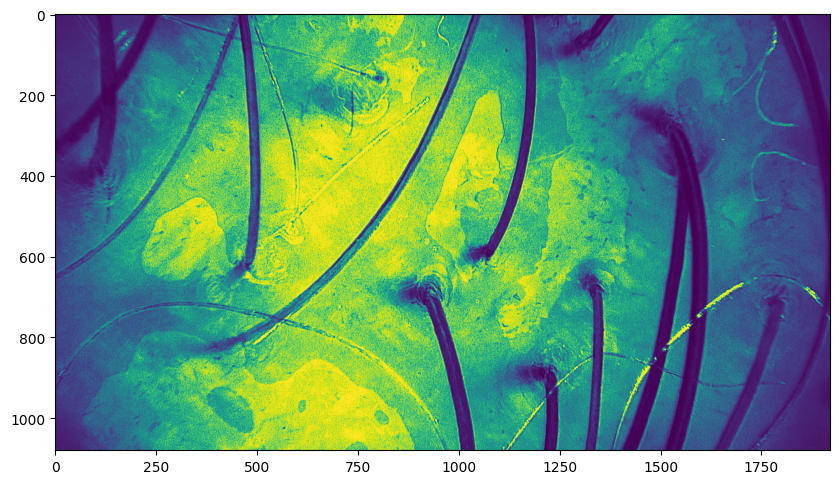

In [ ]:
image = cv2.imread("./łysienie/03945.jpg") #03943.jpg

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

equalized1 = cv2.equalizeHist(hsv[:,:,0])
equalized2 = cv2.equalizeHist(hsv[:,:,1])
equalized3 = cv2.equalizeHist(hsv[:,:,2])



plt.figure(figsize=(10,8))
plt.imshow(hsv[:,:,0])

plt.figure(figsize=(10,8))
plt.imshow(equalized1)




plt.figure(figsize=(10,8))
plt.imshow(hsv[:,:,1])

plt.figure(figsize=(10,8))
plt.imshow(equalized2)


plt.figure(figsize=(10,8))
plt.imshow(hsv[:,:,2])

plt.figure(figsize=(10,8))
plt.imshow(equalized3)